In [1]:
## 20170421 runs PD logistic regression models for all banks
## 20170519 modified to product logistic PDs for 2015 and 2016 quarters
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import timedelta  ## use this to increment targ by 1 year!!!!
import time
from time import gmtime, strftime

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import dmatrices
#import random

import sys
import os
os.chdir('C:/BankRisk')

In [2]:
rk = pd.read_csv("BkAvgAstPR_FailDate_BHC2_ult201612.csv", index_col=0)  # ultcert version
rk['xAsOf'] = pd.to_datetime(rk['xAsOf'])
rk['nAsOf'] = pd.to_datetime(rk['nAsOf'])
rk['FailDate'] = pd.to_datetime(rk['FailDate'])
rk.tail(3)

Rank   IDRSSD      xAsOf                                        xName  \
10759  10760  2809355 2002-09-30             FIRST TRUST COMPANY OF ONAGA, NA   
10760  10761  3037904 2002-06-30  MARQUETTE TRUST COMPANY OF SOUTH DAKOTA, NA   
10761  10762  3874891 2008-12-31          TEXAS FIRST BANK - RETAINED CHARTER   

      xState    xCert      nAsOf FailDate BkClass  Offices    ...     aeTotLn  \
10759     KS  35589.0 2001-03-31      NaT     NaN      NaN    ...         0.0   
10760     SD  57326.0 2001-12-31      NaT     NaN      NaN    ...         0.0   
10761     TX  21960.0 2008-12-31      NaT      NM      1.0    ...         0.0   

       aeDDep aeFDep  aeTotDep        pr_eTA    pr_eTAcs  pr_eTL  pr_eTLcs  \
10759     0.0    0.0       0.0  4.598538e-06   99.999998     0.0     100.0   
10760     0.0    0.0       0.0  1.917307e-06  100.000000     0.0     100.0   
10761    66.0    0.0      66.0  4.328697e-07  100.000000     0.0     100.0   

             pr_eDD   pr_eDDcs  
10759  0.000000e+00  107.04051  
10760  0.000000e+00  107.04051  
10761  7.605887e-07  107.04051  

[3 rows x 27 columns]

In [3]:
dfz = pd.read_csv("df3z_201612_allbanks.csv") # 20160521 update
dfz['AsOf'] = pd.to_datetime(dfz['AsOf'])
#dfz = dfz[dfz['AsOf']<='2014-12-31']  # does not work if AsOf > 2014-12-31 (this has been fixed: 20170519)
dfcol = list(dfz.columns)
dfz.columns

Index(['Unnamed: 0', 'IDRSSD', 'AsOf', 'Name', 'State', 'Cert', 'eTotAst',
       'qNetInc', 'qNetII', 'qProv',
       ...
       'eTotrb', 'eALLL_Ln', 'mxCx', 'mxSfFst', 'mxCRE', 'mxCI', 'mxCard',
       'mxDDA', 'eRWA_TA', 'lnTotAst'],
      dtype='object', length=134)

In [4]:
len(dfz) # 481187

481187

In [5]:
rk[0:5]

Rank  IDRSSD      xAsOf                    xName xState    xCert  \
0     1  852218 2016-12-31  JPMORGAN CHASE BANK, NA     OH    628.0   
1     2  480228 2016-12-31      BANK OF AMERICA, NA     NC   3510.0   
2     3  476810 2016-12-31           CITIBANK, N.A.     SD   7213.0   
3     4  451965 2016-12-31     WELLS FARGO BANK, NA     SD   3511.0   
4     5  484422 2009-12-31        WACHOVIA BANK, NA     NC  33869.0   

       nAsOf   FailDate BkClass  Offices    ...           aeTotLn  \
0 2001-03-31        NaT       N   5417.0    ...      4.808213e+08   
1 2001-03-31 2009-01-16       N   4706.0    ...      6.332250e+08   
2 2001-03-31 2008-11-23       N    756.0    ...      4.930308e+08   
3 2001-03-31        NaT       N   6194.0    ...      4.884076e+08   
4 2001-03-31        NaT       N   3312.0    ...      2.546369e+08   

         aeDDep        aeFDep      aeTotDep    pr_eTA   pr_eTAcs    pr_eTL  \
0  6.097738e+08  2.526110e+08  8.623848e+08  9.155524   9.155524  5.541019   
1  7.478789e+08  1.083941e+08  8.562730e+08  7.936602  17.092126  7.297330   
2  2.606809e+08  4.333959e+08  6.940768e+08  6.698479  23.790605  5.681723   
3  5.403720e+08  6.454305e+07  6.049150e+08  5.181410  28.972015  5.628445   
4  2.704156e+08  2.469325e+07  2.951088e+08  2.896596  31.868612  2.934454   

    pr_eTLcs    pr_eDD   pr_eDDcs  
0   5.541019  7.027077   7.027077  
1  12.838349  8.618610  15.645687  
2  18.520072  3.004105  18.649792  
3  24.148517  6.227286  24.877077  
4  27.082971  3.116289  27.993366  

[5 rows x 27 columns]

In [6]:
dfcol[-56:][0:5]  ## want to start with rcTotLn as first of all ratios

['rcTotLn', 'rcCx', 'rcSfRev', 'rcSfTD', 'rcMult']

In [7]:
xcol=['rcTotLn','qnTotLn','rNIM','rPPNR','rROA','rROE','rEff','eLn_Dep','aFF_TA','eBrok_Dep','eT1rb','eTotrb','eALLL_Ln','lnTotAst']
#xcol=['rcTotLn','qnTotLn','rNIM','rPPNR','rROA','rROE','rEff','eLn_Dep','aFF_TA','eT1rb','eTotrb','eALLL_Ln','lnTotAst']
xcol

['rcTotLn',
 'qnTotLn',
 'rNIM',
 'rPPNR',
 'rROA',
 'rROE',
 'rEff',
 'eLn_Dep',
 'aFF_TA',
 'eBrok_Dep',
 'eT1rb',
 'eTotrb',
 'eALLL_Ln',
 'lnTotAst']

In [8]:
#dfz['AsOf'] = pd.to_datetime(dfz['AsOf'])
dfr = dfz[dfz['AsOf']>='2001-12-31'][['IDRSSD','AsOf','Name','State','eTotAst']+xcol]

In [9]:
dfr.tail(2)

IDRSSD       AsOf          Name State  eTotAst  rcTotLn  qnTotLn  \
481185  4845861 2016-09-30  PRIMARY BANK    NH  71017.0      0.0      0.0   
481186  4845861 2016-12-31  PRIMARY BANK    NH  90549.0      0.0      0.0   

            rNIM     rPPNR      rROA      rROE        rEff     eLn_Dep  \
481185  2.461593 -3.611043 -5.010108 -8.610136  270.505051  120.735763   
481186  2.500239 -2.323936 -3.615393 -7.902975  192.744695  103.055012   

           aFF_TA  eBrok_Dep      eT1rb     eTotrb  eALLL_Ln   lnTotAst  
481185  28.552578        0.0  44.208795  45.368211  1.286180  11.170675  
481186  23.438327        0.0  34.437464  35.568103  1.285549  11.413646

In [10]:
len(dfr) # 454782

454782

In [11]:
## add faildate (if it hasn't already been added):
if 'FailDate' not in list(dfr.columns): dfr = dfr.merge(rk[['IDRSSD','FailDate']],how='left',on='IDRSSD')

In [12]:
## calculate months-to-fail (mtf) and fail flags (f6 and f12):
dfr['mtf'] = ((dfr['FailDate'] - dfr['AsOf'])/np.timedelta64(1,'M')) 
dfr['mtf2'] = dfr.apply(lambda x: round(x['mtf'],0),axis=1)
dfr['f2'] = ((dfr['mtf'] <= 6.0) & (dfr['mtf'] >= 0.0))*1
dfr['f4'] = ((dfr['mtf'] <= 12.0) & (dfr['mtf'] >= 0.0))*1
dfr['f6'] = ((dfr['mtf'] <= 18.0) & (dfr['mtf'] >= 0.0))*1
dfr['f8'] = ((dfr['mtf'] <= 24.0) & (dfr['mtf'] >= 0.0))*1
dfr[dfr['FailDate']>'1990'].tail(10)

IDRSSD       AsOf                   Name State  eTotAst    rcTotLn  \
450875  3640854 2010-12-31  PISGAH COMMUNITY BANK    NC  42376.0  28.150487   
450876  3640854 2011-03-31  PISGAH COMMUNITY BANK    NC  37254.0   8.929288   
450877  3640854 2011-06-30  PISGAH COMMUNITY BANK    NC  30273.0   8.503535   
450878  3640854 2011-09-30  PISGAH COMMUNITY BANK    NC  30326.0   6.575220   
450879  3640854 2011-12-31  PISGAH COMMUNITY BANK    NC  28120.0   1.430248   
450880  3640854 2012-03-31  PISGAH COMMUNITY BANK    NC  27152.0   2.384150   
450881  3640854 2012-06-30  PISGAH COMMUNITY BANK    NC  27272.0   3.607183   
450882  3640854 2012-09-30  PISGAH COMMUNITY BANK    NC  27126.0   2.767538   
450883  3640854 2012-12-31  PISGAH COMMUNITY BANK    NC  24844.0   3.571429   
450884  3640854 2013-03-31  PISGAH COMMUNITY BANK    NC  21880.0   4.476975   

          qnTotLn      rNIM     rPPNR       rROA ...    eTotrb   eALLL_Ln  \
450875  23.925972  1.477079 -1.921769 -18.226779 ...  1.820415   4.658121   
450876  17.008591  1.501112 -3.117728 -10.539127 ...  4.962240   9.265289   
450877  21.446963  1.627686 -4.269489 -10.664828 ...  4.205588   9.130049   
450878  22.193740  1.812781 -5.113951 -11.027282 ...  3.881005   8.688613   
450879  18.812332  2.028930 -6.126587  -9.089617 ...  4.278839   9.745355   
450880  25.039539  2.097654 -6.350320  -6.577475 ...  4.561760  10.918437   
450881  24.826110  2.210453 -7.173657  -7.180697 ...  4.254765   8.768801   
450882  30.337148  2.105704 -7.160776  -7.164372 ...  4.221197   8.890119   
450883  20.492884  1.927205 -7.261747  -7.265452 ...  4.766264   9.330094   
450884  19.035231  1.919126 -6.838070  -5.395423 ...  5.006596   6.525940   

         lnTotAst   FailDate        mtf  mtf2  f2  f4  f6 f8  
450875  10.654337 2013-05-10  28.288055  28.0   0   0   0  0  
450876  10.525515 2013-05-10  25.331116  25.0   0   0   0  0  
450877  10.318012 2013-05-10  22.341321  22.0   0   0   0  1  
450878  10.319761 2013-05-10  19.318672  19.0   0   0   0  1  
450879  10.244236 2013-05-10  16.296023  16.0   0   0   1  1  
450880  10.209206 2013-05-10  13.306228  13.0   0   0   1  1  
450881  10.213616 2013-05-10  10.316434  10.0   0   1   1  1  
450882  10.208248 2013-05-10   7.293784   7.0   0   1   1  1  
450883  10.120372 2013-05-10   4.271135   4.0   1   1   1  1  
450884   9.993328 2013-05-10   1.314195   1.0   1   1   1  1  

[10 rows x 26 columns]

In [13]:
dfr[dfr['FailDate']>'1990'][['AsOf','IDRSSD','FailDate','mtf','mtf2']].tail(10)

AsOf   IDRSSD   FailDate        mtf  mtf2
450875 2010-12-31  3640854 2013-05-10  28.288055  28.0
450876 2011-03-31  3640854 2013-05-10  25.331116  25.0
450877 2011-06-30  3640854 2013-05-10  22.341321  22.0
450878 2011-09-30  3640854 2013-05-10  19.318672  19.0
450879 2011-12-31  3640854 2013-05-10  16.296023  16.0
450880 2012-03-31  3640854 2013-05-10  13.306228  13.0
450881 2012-06-30  3640854 2013-05-10  10.316434  10.0
450882 2012-09-30  3640854 2013-05-10   7.293784   7.0
450883 2012-12-31  3640854 2013-05-10   4.271135   4.0
450884 2013-03-31  3640854 2013-05-10   1.314195   1.0

In [14]:
## issues:  Ln_Dep, Brok_Dep ratios:
dfr[['eLn_Dep','aFF_TA','eBrok_Dep','eALLL_Ln']].max()

eLn_Dep      1.188277e+08
aFF_TA       1.242405e+03
eBrok_Dep    7.002056e+03
eALLL_Ln     1.500000e+04
dtype: float64

In [15]:
dfr.ix[dfr['eLn_Dep'].idxmax()]

IDRSSD                               3376461
AsOf                     2005-09-30 00:00:00
Name         LEHMAN BROTHERS COMMERCIAL BANK
State                                     UT
eTotAst                          1.32523e+06
rcTotLn                                  NaN
qnTotLn                                    0
rNIM                                     NaN
rPPNR                                    NaN
rROA                                     NaN
rROE                                     NaN
rEff                                     NaN
eLn_Dep                          1.18828e+08
aFF_TA                               3.85946
eBrok_Dep                                  0
eT1rb                                15.0255
eTotrb                               15.0255
eALLL_Ln                                   0
lnTotAst                             14.0971
FailDate                                 NaT
mtf                                      NaN
mtf2                                     NaN
f2        

In [16]:
## Don't run this unless something has changed!!!!!!!!!
dfr.to_csv("logistic_rawdata.csv")

In [17]:
len(dfr) # 454782

454782

In [18]:
dfr.columns

Index(['IDRSSD', 'AsOf', 'Name', 'State', 'eTotAst', 'rcTotLn', 'qnTotLn',
       'rNIM', 'rPPNR', 'rROA', 'rROE', 'rEff', 'eLn_Dep', 'aFF_TA',
       'eBrok_Dep', 'eT1rb', 'eTotrb', 'eALLL_Ln', 'lnTotAst', 'FailDate',
       'mtf', 'mtf2', 'f2', 'f4', 'f6', 'f8'],
      dtype='object')

In [19]:
## curr date is 2010-12-31, but cut off dataset at 2009-12-31, then adjust for any fail flags later than 2010-12-31:
targ = pd.to_datetime('2009-12-31')
thresh = 0
alt = 'roe' ## or alt = ''  # add rROE >=-200 screening test
dfh = dfr[(dfr['AsOf']<=targ)][['IDRSSD','AsOf','Name','FailDate','f2','f4','f6','f8']+xcol]
#dfr09 = sm.add_constant(dfr09)
len(dfh) # 265388

265388

In [20]:
dfh.columns[8:]

Index(['rcTotLn', 'qnTotLn', 'rNIM', 'rPPNR', 'rROA', 'rROE', 'rEff',
       'eLn_Dep', 'aFF_TA', 'eBrok_Dep', 'eT1rb', 'eTotrb', 'eALLL_Ln',
       'lnTotAst'],
      dtype='object')

In [21]:
dfh[['eLn_Dep','aFF_TA','eBrok_Dep','eALLL_Ln']].max()

eLn_Dep      1.188277e+08
aFF_TA       1.242405e+03
eBrok_Dep    7.002056e+03
eALLL_Ln     1.500000e+04
dtype: float64

In [22]:
## screening criteria, remove outliers: (10/29/15 add eT1rb and lnTotAst screens)
dfh.dropna(how='any',inplace=True,subset=dfh.columns[8:])  # delete any ratio columns with NaN values (note columns[8:])
dfh= dfh[dfh['eLn_Dep']<=1000]
dfh= dfh[dfh['eBrok_Dep']<=100]
dfh= dfh[dfh['eALLL_Ln']<=100]
dfh= dfh[dfh['rROE']>=-200]
dfh= dfh[dfh['eT1rb']<=200]   # added 10/29/15
dfh= dfh[dfh['lnTotAst']>=2]  # added 10/29/15
len(dfh) # 259210

259210

In [23]:
# 20160428 handles leap years now.
targ2 = pd.to_datetime(targ.day + targ.month*100 + (targ.year + 1)*10000,format='%Y%m%d')
targ2, targ

(Timestamp('2010-12-31 00:00:00'), Timestamp('2009-12-31 00:00:00'))

In [24]:
## set fflags to zero if FailDate after target date (12/31/2009); that is, for f4
dfh.ix[dfh.FailDate>targ2,['f2','f4','f6','f8']] = [0,0,0,0]

In [25]:
dfh.ix[(dfh.FailDate>'2010-09-01')&(dfh.FailDate<'2012-01-01')&(dfh.AsOf>'2009-09-01'),\
       ['IDRSSD','AsOf','Name','FailDate','f2','f4','f6','f8']].head()

IDRSSD       AsOf                 Name   FailDate  f2  f4  f6  f8
5236   16337 2009-09-30         WAKULLA BANK 2010-10-01   0   0   1   1
5237   16337 2009-12-31         WAKULLA BANK 2010-10-01   0   1   1   1
6751   20370 2009-09-30  FIRST HERITAGE BANK 2011-05-27   0   0   0   0
6752   20370 2009-12-31  FIRST HERITAGE BANK 2011-05-27   0   0   0   0
7842   23241 2009-09-30      INTEGRA BANK NA 2011-07-29   0   0   0   0

In [26]:
## regressions:
fml = 'f4 ~ ' + ' + '.join(xcol)
fml

'f4 ~ rcTotLn + qnTotLn + rNIM + rPPNR + rROA + rROE + rEff + eLn_Dep + aFF_TA + eBrok_Dep + eT1rb + eTotrb + eALLL_Ln + lnTotAst'

In [27]:
try:
  md = smf.logit(formula=fml, data=dfh).fit()
  print(md.summary())
except:
  print("Full model didn't work")

         Current function value: inf
         Iterations: 35
Full model didn't work


In [28]:
## stepwise regressions:
print(datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

## create 2-var models:
topx = 2
def dv1_topx(group):
  return group.sort_index(by='r1', ascending=False)[:topx]

dv1 = pd.DataFrame(columns=['fx','v1', 'r1']) # c1: category1, v1: variable1, r1: rsquared1
for fx in ['f2','f4','f6']:
  for v in xcol:
    y, X = dmatrices( fx + ' ~ ' + v , data=dfh, return_type='dataframe')
    try:
      res = sm.Logit(y, X).fit()
      dv1 = dv1.append({'fx': fx,'v1': v, 'r1': res.prsquared}, ignore_index=True)
    except:
      pass

dv1g = dv1.groupby(['fx'])
dv1t = dv1g.apply(dv1_topx)
dv1t.index = np.arange(len(dv1t))

# stores r-sq values for all 2-var combos:
dv2 = pd.DataFrame(columns=['fx','v1', 'r1', 'v2', 'r2'])
st2 = set(frozenset({'fx','x', 'y'}))  # to retain processed var-pairs

for idx, row in dv1t.iterrows():
  for v in xcol:
    if (row['v1'] == v) | ({row['fx'], v , row['v1']} in st2):
      pass
    else:
      y, X = dmatrices( row['fx'] + ' ~ ' + row['v1'] + ' + ' + v , data = dfh, return_type='dataframe')
      try:
        res = sm.Logit(y, X).fit()
        dv2 = dv2.append({'fx':row['fx'], 'v1':row['v1'], 'r1':row['r1'], 'v2':v, 'r2': res.prsquared}, ignore_index=True)
      except:
        pass
      st2.add(frozenset({row['fx'], v, row['v1']}))

print(datetime.now().strftime("%Y-%m-%d %H:%M:%S"))


2017-05-20 12:01:41
Optimization terminated successfully.
         Current function value: 0.010368
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.009019
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.010373
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.010116
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.008902
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.005301
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.010372
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.010353
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.010345
         Iterations 11
Optimization terminated successfully.
         Curren

In [29]:
dv1t

fx      v1        r1
0  f2   eT1rb  0.522181
1  f2  eTotrb  0.498840
2  f4   eT1rb  0.399541
3  f4    rROE  0.397054
4  f6    rROE  0.300326
5  f6   eT1rb  0.292186

In [30]:
# function to select topx for each lead variable:
def get_topx_2var(group):
  return group.sort_index(by=['r2','r1'], ascending=False)[:topx]

grouped = dv2.groupby(['fx'])
dv2a = grouped.apply(get_topx_2var)
dv2a = dv2a.sort_index(by=['fx','r2','r1'], ascending=[True,False,False])
dv2a.index = np.arange(len(dv2a))
dv2a

fx     v1        r1       v2        r2
0  f2  eT1rb  0.522181     rROE  0.572503
1  f2  eT1rb  0.522181  qnTotLn  0.564419
2  f4  eT1rb  0.399541  qnTotLn  0.485642
3  f4  eT1rb  0.399541     rROE  0.477492
4  f6  eT1rb  0.292186  qnTotLn  0.398684
5  f6  eT1rb  0.292186     rROA  0.378671

In [31]:
print(datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
# prep for 3-var combos:
# stores r-sq values for all 3-var combos:
dv3 = pd.DataFrame(columns=['idx','fx','v1', 'r1', 'v2', 'r2', 'v3', 'r3'])
cv3 = pd.DataFrame(columns=['idx','v3','Int','c1','c2','c3'])
st3 = set(frozenset({'fx','x', 'y', 'z'}))  # to retain processed var-triples

for idx, row in dv2a.iterrows():
  for v in xcol:
    if (row['v1'] == v) | (row['v2'] == v) :
      pass
    elif {row['fx'], v , row['v1'], row['v2']} in st3:
      pass
    else:
      y, X = dmatrices( row['fx'] + ' ~ ' + row['v1'] + ' + ' + row['v2'] + ' + ' + v , data = dfh, return_type='dataframe')
      try:
        st3.add(frozenset({row['fx'],v, row['v1'], row['v2']}))
        res = sm.Logit(y, X).fit()
        dv3 = dv3.append({'idx':idx,'fx':row['fx'],'v1':row['v1'],'r1':row['r1'],'v2':row['v2'],\
                          'r2':row['r2'],'v3':v,'r3': res.prsquared},ignore_index=True)
        cm = pd.DataFrame(res.params).T
        cm.columns = ['Int','c1','c2','c3']
        cm['idx'] = idx
        cm['v3'] = v
        cv3 = cv3.append(cm.ix[0])
      except:
        pass

cv3arch = cv3.copy()
dv3arch = dv3.copy()
#cv3.reset_index(drop=True,inplace=True)
dv3.reset_index(drop=True,inplace=True)
dv3 = dv3.merge(cv3, how='inner', on=['idx','v3'])

print(datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

2017-05-20 12:03:13
         Current function value: inf
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.004194
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.004434
         Iterations 19
Optimization terminated successfully.
         Current function value: 0.004434
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.004419
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.004434
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.004423
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.004411
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.004216
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.004406
         Iterat

In [32]:
topn = 2
# function to select top 3 for each lead variable:
def get_topx_3var(group):
  return group.sort_index(by=['r3','r2','r1'], ascending=False)[:topx]

def get_topn_rc(group):
  return group.sort_index(by=['r3','r2','r1'], ascending=False)[:topn]

dv3g = dv3.groupby(['fx','v1','v2'])  #  allows topx for each primary 2-var pair
dv3a = dv3g.apply(get_topx_3var)  ## finds best topx models from each 3-var combo
dv3ag = dv3a.groupby(['fx'])  # prep to find topn best models for each product category
dv3b = dv3ag.apply(get_topn_rc)  # find topn models among all 3-var models
dv3b.index = np.arange(len(dv3b))
dv3b

idx  fx     v1        r1       v2        r2         v3        r3       Int  \
0  0.0  f2  eT1rb  0.522181     rROE  0.572503    qnTotLn  0.595651 -2.376700   
1  0.0  f2  eT1rb  0.522181     rROE  0.572503  eBrok_Dep  0.593579 -2.262260   
2  2.0  f4  eT1rb  0.399541  qnTotLn  0.485642       rROA  0.520306 -0.551524   
3  2.0  f4  eT1rb  0.399541  qnTotLn  0.485642       rROE  0.517804 -1.591131   
4  4.0  f6  eT1rb  0.292186  qnTotLn  0.398684  eBrok_Dep  0.432376 -0.262304   
5  4.0  f6  eT1rb  0.292186  qnTotLn  0.398684       rROA  0.427395 -0.786348   

         c1        c2        c3  
0 -0.477164 -0.025604  0.087899  
1 -0.501399 -0.029879  0.038361  
2 -0.525912  0.125261 -0.325274  
3 -0.423253  0.123065 -0.028369  
4 -0.534329  0.213801  0.041452  
5 -0.429293  0.156714 -0.303840

In [33]:
print(datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
# prep for 4-var combos:
# stores r-sq values for all 3-var combos:
dv4 = pd.DataFrame(columns=['idx','fx','v1', 'r1', 'v2', 'r2','v3', 'r3','v4','r4'])
cv4 = pd.DataFrame(columns=['idx','v4','Int','c1','c2','c3','c4'])
st4 = set(frozenset({'fx','w','x', 'y', 'z'}))  # to retain processed var-triples

for idx, row in dv3b.iterrows():
  for v in xcol:
    if (row['v1'] == v) | (row['v2'] == v) | (row['v3'] == v):
      pass
    elif {row['fx'], v , row['v1'], row['v2'], row['v3']} in st4:
      pass
    else:
      y, X = dmatrices( row['fx']+' ~ '+ row['v1'] +' + '+ row['v2'] +' + '+ row['v3'] +' + '+ v , data = dfh, return_type='dataframe')
      st4.add(frozenset({row['fx'],v, row['v1'], row['v2'], row['v3']}))
      try:
        res = sm.Logit(y, X).fit()
        dv4 = dv4.append({'idx':idx,'fx':row['fx'],'v1':row['v1'],'r1':row['r1'],'v2':row['v2'],'r2':row['r2'],\
                          'v3':row['v3'],'r3': row['r3'], 'v4':v,'r4': res.prsquared},ignore_index=True)
        cm = pd.DataFrame(res.params).T
        cm.columns = ['Int','c1','c2','c3','c4']
        cm['idx'] = idx
        cm['v4'] = v
        cv4 = cv4.append(cm.ix[0])
      except:
        pass

cv4 = cv4.reset_index(drop=True)
dv4 = dv4.reset_index(drop=True)
dv4 = dv4.merge(cv4, how='inner', on=['idx','v4'])

print(datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

2017-05-20 12:04:15
Optimization terminated successfully.
         Current function value: 0.004194
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.004194
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.004194
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.004189
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.004194
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.004176
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.004182
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.004026
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.004165
         Iterations 15
Optimization terminated successfully.
         Curren

In [34]:
# function to select top 2 for each lead variable set:
def get_topx_4var(group):
  return group.sort_index(by=['r4','r3','r2','r1'], ascending=False)[:3]

def get_topn_4fx(group):
  return group.sort_index(by=['r4','r3','r2','r1'], ascending=False)[:2]

dv4g = dv4.groupby(['fx','v1','v2','v3'])  #  allows topx for each primary 2-var pair
dv4a = dv4g.apply(get_topx_4var)  ## finds best topx models from each 3-var combo
dv4ag = dv4a.groupby(['fx'])  # prep to find topn best models for each product category
dv4b = dv4ag.apply(get_topn_4fx)  # find topn models among all 3-var models
dv4b.index = np.arange(len(dv4b))
dv4b

idx  fx     v1        r1       v2        r2         v3        r3  \
0  0.0  f2  eT1rb  0.522181     rROE  0.572503    qnTotLn  0.595651   
1  0.0  f2  eT1rb  0.522181     rROE  0.572503    qnTotLn  0.595651   
2  3.0  f4  eT1rb  0.399541  qnTotLn  0.485642       rROE  0.517804   
3  2.0  f4  eT1rb  0.399541  qnTotLn  0.485642       rROA  0.520306   
4  4.0  f6  eT1rb  0.292186  qnTotLn  0.398684  eBrok_Dep  0.432376   
5  4.0  f6  eT1rb  0.292186  qnTotLn  0.398684  eBrok_Dep  0.432376   

          v4        r4       Int        c1        c2        c3        c4  
0  eBrok_Dep  0.611862 -2.799821 -0.473018 -0.024956  0.084633  0.034710  
1   lnTotAst  0.605721 -6.621866 -0.450454 -0.028631  0.084570  0.310076  
2  eBrok_Dep  0.544661 -2.201785 -0.405928  0.112205 -0.028430  0.041345  
3  eBrok_Dep  0.543345 -0.967992 -0.524373  0.116511 -0.308563  0.038837  
4       rROA  0.460139 -1.308207 -0.418959  0.145417  0.042005 -0.288694  
5       rROE  0.458442 -2.075903 -0.346558  0.140125  0.043327 -0.025636

In [35]:
dv4b.to_csv("f246_params_"+alt+str(thresh)+"mm2_2009.csv")

In [36]:
dnbr=dfr[['AsOf','f2','f4','f6','f8']].groupby('AsOf').sum()
dnbr['2009':'2011']

f2   f4   f6   f8
AsOf                         
2009-03-31  63  135  205  256
2009-06-30  79  153  211  254
2009-09-30  72  142  193  236
2009-12-31  74  132  175  216
2010-03-31  70  121  163  194
2010-06-30  58  101  142  166
2010-09-30  51   94  124  145
2010-12-31  43   84  108  124
2011-03-31  42   73   94  104
2011-06-30  41   65   81   96
2011-09-30  30   51   61   78
2011-12-31  24   40   55   63

In [37]:
dnbr['2014':'2016']

f2  f4  f6  f8
AsOf                      
2014-03-31   8  16  18  21
2014-06-30   6  11  14  17
2014-09-30   8  10  13  17
2014-12-31   5   8  11  13
2015-03-31   2   5   9   9
2015-06-30   3   6   8   8
2015-09-30   3   7   7   7
2015-12-31   3   5   5   5
2016-03-31   4   4   4   4
2016-06-30   2   2   2   2
2016-09-30   0   0   0   0
2016-12-31   0   0   0   0

In [38]:
### run forecasts in dff:

In [39]:
dff = dfr.copy()
len(dff) # 454782

454782

In [40]:
dff = dff[dff['eLn_Dep']<=1000]
dff = dff[dff['eBrok_Dep']<=100]
dff = dff[dff['eALLL_Ln']<=100]
dff = dff[dff['rROE']>=-200]
dff= dff[dff['eT1rb']<=200]   # added 10/29/15
dff= dff[dff['lnTotAst']>=2]  # added 10/29/15
len(dff) # 444470

444470

In [41]:
# Add intercept:
dff['Intercept'] = 1.
dff.tail(2)

IDRSSD       AsOf          Name State  eTotAst  rcTotLn  qnTotLn  \
454780  4845861 2016-09-30  PRIMARY BANK    NH  71017.0      0.0      0.0   
454781  4845861 2016-12-31  PRIMARY BANK    NH  90549.0      0.0      0.0   

            rNIM     rPPNR      rROA    ...     eALLL_Ln   lnTotAst  FailDate  \
454780  2.461593 -3.611043 -5.010108    ...     1.286180  11.170675       NaT   
454781  2.500239 -2.323936 -3.615393    ...     1.285549  11.413646       NaT   

        mtf  mtf2  f2  f4  f6  f8 Intercept  
454780  NaN   NaN   0   0   0   0       1.0  
454781  NaN   NaN   0   0   0   0       1.0  

[2 rows x 27 columns]

In [42]:
## rerun models for dfh and dff tables:
dv4r = pd.DataFrame(columns=['idx','fx','v1', 'r1', 'v2', 'r2','v3', 'r3','v4','r4'])
cv4r = pd.DataFrame(columns=['idx','v4','Int','c1','c2','c3','c4'])

for idx, row in dv4b.iterrows():
  fv = row['fx']
  x = idx
  eqnc = fv + " ~ " + " + ".join(row[['v1', 'v2', 'v3','v4']])  # regression eqn
  pvar = ["Intercept", row['v1'], row['v2'], row['v3'], row['v4']]  # vars for predictions
  yc, Xc = dmatrices(eqnc , data=dfh, return_type='dataframe')
  res = sm.Logit(yc, Xc).fit()
  dv4r = dv4r.append({'idx':idx,'fx':row['fx'],'v1':row['v1'],'r1':row['r1'],'v2':row['v2'],'r2':row['r2'],\
                    'v3':row['v3'],'r3': row['r3'], 'v4':row['v4'],'r4': res.prsquared},ignore_index=True)
  cmr = pd.DataFrame(res.params).T
  cmr.columns = ['Int','c1','c2','c3','c4']
  cmr['idx'] = idx
  cmr['v4'] = row['v4']
  cv4r = cv4r.append(cmr.ix[0])
  pred_tot = res.predict(Xc)
  dfh[fv+'_'+str(x)] = pred_tot
  p_tot = res.predict(dff[pvar])  # forecasts  dff: future vars
  dff[fv+'_'+str(x)] = p_tot

cv4r = cv4r.reset_index(drop=True)
dv4r = dv4r.reset_index(drop=True)
dv4r = dv4r.merge(cv4r, how='inner', on=['idx','v4'])

Optimization terminated successfully.
         Current function value: 0.004026
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.004090
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.010472
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.010502
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.018770
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.018829
         Iterations 12


In [43]:
dv4r

idx  fx     v1        r1       v2        r2         v3        r3  \
0  0.0  f2  eT1rb  0.522181     rROE  0.572503    qnTotLn  0.595651   
1  1.0  f2  eT1rb  0.522181     rROE  0.572503    qnTotLn  0.595651   
2  2.0  f4  eT1rb  0.399541  qnTotLn  0.485642       rROE  0.517804   
3  3.0  f4  eT1rb  0.399541  qnTotLn  0.485642       rROA  0.520306   
4  4.0  f6  eT1rb  0.292186  qnTotLn  0.398684  eBrok_Dep  0.432376   
5  5.0  f6  eT1rb  0.292186  qnTotLn  0.398684  eBrok_Dep  0.432376   

          v4        r4       Int        c1        c2        c3        c4  
0  eBrok_Dep  0.611862 -2.799821 -0.473018 -0.024956  0.084633  0.034710  
1   lnTotAst  0.605721 -6.621866 -0.450454 -0.028631  0.084570  0.310076  
2  eBrok_Dep  0.544661 -2.201785 -0.405928  0.112205 -0.028430  0.041345  
3  eBrok_Dep  0.543345 -0.967992 -0.524373  0.116511 -0.308563  0.038837  
4       rROA  0.460139 -1.308207 -0.418959  0.145417  0.042005 -0.288694  
5       rROE  0.458442 -2.075903 -0.346558  0.140125  0.043327 -0.025636

In [44]:
dv4b

idx  fx     v1        r1       v2        r2         v3        r3  \
0  0.0  f2  eT1rb  0.522181     rROE  0.572503    qnTotLn  0.595651   
1  0.0  f2  eT1rb  0.522181     rROE  0.572503    qnTotLn  0.595651   
2  3.0  f4  eT1rb  0.399541  qnTotLn  0.485642       rROE  0.517804   
3  2.0  f4  eT1rb  0.399541  qnTotLn  0.485642       rROA  0.520306   
4  4.0  f6  eT1rb  0.292186  qnTotLn  0.398684  eBrok_Dep  0.432376   
5  4.0  f6  eT1rb  0.292186  qnTotLn  0.398684  eBrok_Dep  0.432376   

          v4        r4       Int        c1        c2        c3        c4  
0  eBrok_Dep  0.611862 -2.799821 -0.473018 -0.024956  0.084633  0.034710  
1   lnTotAst  0.605721 -6.621866 -0.450454 -0.028631  0.084570  0.310076  
2  eBrok_Dep  0.544661 -2.201785 -0.405928  0.112205 -0.028430  0.041345  
3  eBrok_Dep  0.543345 -0.967992 -0.524373  0.116511 -0.308563  0.038837  
4       rROA  0.460139 -1.308207 -0.418959  0.145417  0.042005 -0.288694  
5       rROE  0.458442 -2.075903 -0.346558  0.140125  0.043327 -0.025636

In [45]:
## annotations for graphs: vars & r-sq:
df4lst1 = []
df4lst2 = []
for i in np.arange(len(dv4r)):
  ds1 = dv4r.ix[i]['v1'] + ', ' + dv4r.ix[i]['v2'] + ', ' 
  ds2 = dv4r.ix[i]['v3'] + ',' + dv4r.ix[i]['v4'] +': '+ str(round(dv4r.ix[i]['r4']*100,1))
  df4lst1 = df4lst1 + [ds1]
  df4lst2 = df4lst2 + [ds2]

dv4r['Annot1'] = df4lst1
dv4r['Annot2'] = df4lst2
dv4r.head(2)

idx  fx     v1        r1    v2        r2       v3        r3         v4  \
0  0.0  f2  eT1rb  0.522181  rROE  0.572503  qnTotLn  0.595651  eBrok_Dep   
1  1.0  f2  eT1rb  0.522181  rROE  0.572503  qnTotLn  0.595651   lnTotAst   

         r4       Int        c1        c2        c3        c4         Annot1  \
0  0.611862 -2.799821 -0.473018 -0.024956  0.084633  0.034710  eT1rb, rROE,    
1  0.605721 -6.621866 -0.450454 -0.028631  0.084570  0.310076  eT1rb, rROE,    

                    Annot2  
0  qnTotLn,eBrok_Dep: 61.2  
1   qnTotLn,lnTotAst: 60.6

In [46]:
dff.head()

IDRSSD       AsOf                    Name State  eTotAst   rcTotLn  \
0      37 2001-12-31  BANK OF HANCOCK COUNTY    GA  66624.0  0.320412   
1      37 2002-03-31  BANK OF HANCOCK COUNTY    GA  68766.0  0.261846   
2      37 2002-06-30  BANK OF HANCOCK COUNTY    GA  69304.0  0.364757   
3      37 2002-09-30  BANK OF HANCOCK COUNTY    GA  71970.0  0.495989   
4      37 2002-12-31  BANK OF HANCOCK COUNTY    GA  74327.0  0.610962   

    qnTotLn      rNIM     rPPNR      rROA    ...     f4  f6  f8  Intercept  \
0  0.202341  4.771308  2.035791  1.366385    ...      0   0   0        1.0   
1  0.199812  4.673793  1.952308  1.314604    ...      0   0   0        1.0   
2  0.206747  4.599485  1.927457  1.294383    ...      0   0   0        1.0   
3  0.325492  4.492631  1.833764  1.235163    ...      0   0   0        1.0   
4  0.268236  4.436347  1.816232  1.214158    ...      0   0   0        1.0   

           f2_0          f2_1          f4_2          f4_3          f6_4  \
0  1.816980e-08  2.457995e-08  2.658786e-07  1.808432e-08  3.640110e-07   
1  2.074132e-08  2.819496e-08  2.984160e-07  2.111511e-08  4.128278e-07   
2  2.624992e-08  3.539017e-08  3.656513e-07  2.750531e-08  5.105488e-07   
3  4.456546e-08  5.939042e-08  5.798267e-07  5.008500e-08  8.313529e-07   
4  1.606111e-08  2.269976e-08  2.410813e-07  1.621047e-08  3.368549e-07   

       f6_5  
0  0.000002  
1  0.000002  
2  0.000003  
3  0.000004  
4  0.000002  

[5 rows x 33 columns]

In [47]:
fcol = [x for x in list(dff.columns) if x[0:1]=='f']
fcol

['f2', 'f4', 'f6', 'f8', 'f2_0', 'f2_1', 'f4_2', 'f4_3', 'f6_4', 'f6_5']

In [48]:
fnbr = dff[['AsOf']+fcol].groupby('AsOf').sum()
fnbr.rename(columns={'f2_0':'f2_0f','f2_1':'f2_1f','f4_2':'f4_2f','f4_3':'f4_3f','f6_4':'f6_4f','f6_5':'f6_5f'},inplace=True)
fnbr[['f2_0p','f2_1p','f4_2p','f4_3p','f6_4p','f6_5p']] = fnbr[['f2_0f','f2_1f','f4_2f','f4_3f','f6_4f','f6_5f']]
fnbr.ix[:'2009-12-31',['f2_0p','f2_1p','f4_2p','f4_3p']] = np.nan
fnbr.ix[:'2009-06-30',['f6_4p','f6_5p']] = np.nan
fnbr.loc['2010-03-31':,['f2_0f','f2_1f','f4_2f','f4_3f']] = np.nan
fnbr.loc['2009-09-30':,['f6_4f','f6_5f']] = np.nan

favg = dff[['AsOf']+fcol].groupby('AsOf').mean()
favg.rename(columns={'f2_0':'f2_0f','f2_1':'f2_1f','f4_2':'f4_2f','f4_3':'f4_3f','f6_4':'f6_4f','f6_5':'f6_5f'},inplace=True)
favg[['f2_0p','f2_1p','f4_2p','f4_3p','f6_4p','f6_5p']] = favg[['f2_0f','f2_1f','f4_2f','f4_3f','f6_4f','f6_5f']]
favg.ix[:'2009-12-31',['f2_0p','f2_1p','f4_2p','f4_3p']] = np.nan
favg.ix[:'2009-06-30',['f6_4p','f6_5p']] = np.nan
favg.loc['2010-03-31':,['f2_0f','f2_1f','f4_2f','f4_3f']] = np.nan
favg.loc['2009-09-30':,['f6_4f','f6_5f']] = np.nan

fnbr['2009':'2010']

f2   f4   f6   f8      f2_0f      f2_1f       f4_2f       f4_3f  \
AsOf                                                                          
2009-03-31  55  127  197  248  39.917977  38.468347   91.283776   92.637105   
2009-06-30  59  131  189  232  49.093167  50.077017  109.054071  107.127208   
2009-09-30  52  119  170  213  48.977391  50.292186  113.122369  109.162461   
2009-12-31  62  120  163  204  73.303020  74.859571  150.570430  146.923207   
2010-03-31  53  104  146  177        NaN        NaN         NaN         NaN   
2010-06-30  43   86  127  151        NaN        NaN         NaN         NaN   
2010-09-30  36   78  108  127        NaN        NaN         NaN         NaN   
2010-12-31  34   75   99  115        NaN        NaN         NaN         NaN   

                 f6_4f       f6_5f      f2_0p      f2_1p       f4_2p  \
AsOf                                                                   
2009-03-31  136.599773  133.968930        NaN        NaN         NaN   
2009-06-30  154.836742  155.632097        NaN        NaN         NaN   
2009-09-30         NaN         NaN        NaN        NaN         NaN   
2009-12-31         NaN         NaN        NaN        NaN         NaN   
2010-03-31         NaN         NaN  70.684623  74.628322  140.236146   
2010-06-30         NaN         NaN  58.258775  63.955999  117.360695   
2010-09-30         NaN         NaN  52.636542  58.346461  105.980154   
2010-12-31         NaN         NaN  52.011692  56.621807  105.626960   

                 f4_3p       f6_4p       f6_5p  
AsOf                                            
2009-03-31         NaN         NaN         NaN  
2009-06-30         NaN         NaN         NaN  
2009-09-30         NaN  160.757197  164.020046  
2009-12-31         NaN  197.169234  201.215898  
2010-03-31  127.106464  172.491030  185.328841  
2010-06-30  101.415872  142.563520  158.598685  
2010-09-30   88.228785  125.258839  144.161403  
2010-12-31   94.501162  129.588281  142.706136

In [49]:
favg['2009':'2010']

f2        f4        f6        f8     f2_0f     f2_1f  \
AsOf                                                                     
2009-03-31  0.007443  0.017188  0.026661  0.033563  0.005402  0.005206   
2009-06-30  0.008035  0.017840  0.025739  0.031595  0.006686  0.006820   
2009-09-30  0.007150  0.016362  0.023374  0.029286  0.006734  0.006915   
2009-12-31  0.008587  0.016620  0.022576  0.028255  0.010153  0.010368   
2010-03-31  0.007412  0.014543  0.020417  0.024752       NaN       NaN   
2010-06-30  0.006098  0.012197  0.018012  0.021415       NaN       NaN   
2010-09-30  0.005152  0.011162  0.015455  0.018174       NaN       NaN   
2010-12-31  0.004930  0.010874  0.014354  0.016674       NaN       NaN   

               f4_2f     f4_3f     f6_4f     f6_5f     f2_0p     f2_1p  \
AsOf                                                                     
2009-03-31  0.012354  0.012537  0.018487  0.018131       NaN       NaN   
2009-06-30  0.014851  0.014589  0.021086  0.021195       NaN       NaN   
2009-09-30  0.015554  0.015009       NaN       NaN       NaN       NaN   
2009-12-31  0.020855  0.020349       NaN       NaN       NaN       NaN   
2010-03-31       NaN       NaN       NaN       NaN  0.009885  0.010436   
2010-06-30       NaN       NaN       NaN       NaN  0.008262  0.009070   
2010-09-30       NaN       NaN       NaN       NaN  0.007532  0.008350   
2010-12-31       NaN       NaN       NaN       NaN  0.007541  0.008210   

               f4_2p     f4_3p     f6_4p     f6_5p  
AsOf                                                
2009-03-31       NaN       NaN       NaN       NaN  
2009-06-30       NaN       NaN       NaN       NaN  
2009-09-30       NaN       NaN  0.022103  0.022552  
2009-12-31       NaN       NaN  0.027309  0.027869  
2010-03-31  0.019611  0.017775  0.024121  0.025916  
2010-06-30  0.016645  0.014383  0.020219  0.022493  
2010-09-30  0.015166  0.012626  0.017925  0.020630  
2010-12-31  0.015315  0.013702  0.018789  0.020691

In [50]:
fnbr.to_csv("f246_fnbr_"+alt+str(thresh)+"mm2_2009.csv")
favg.to_csv("f246_favg_"+alt+str(thresh)+"mm2_2009.csv")

In [51]:
dv4r.head(2)

idx  fx     v1        r1    v2        r2       v3        r3         v4  \
0  0.0  f2  eT1rb  0.522181  rROE  0.572503  qnTotLn  0.595651  eBrok_Dep   
1  1.0  f2  eT1rb  0.522181  rROE  0.572503  qnTotLn  0.595651   lnTotAst   

         r4       Int        c1        c2        c3        c4         Annot1  \
0  0.611862 -2.799821 -0.473018 -0.024956  0.084633  0.034710  eT1rb, rROE,    
1  0.605721 -6.621866 -0.450454 -0.028631  0.084570  0.310076  eT1rb, rROE,    

                    Annot2  
0  qnTotLn,eBrok_Dep: 61.2  
1   qnTotLn,lnTotAst: 60.6

In [52]:
## create number charts!!!!!

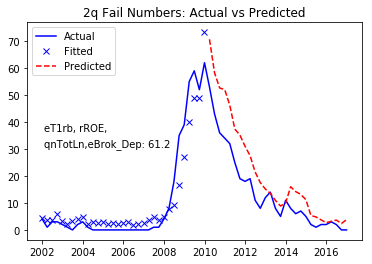

In [53]:
fx = list(fnbr.index)
plt.plot(fx, fnbr['f2'],'b', label='Actual')
plt.plot(fx, fnbr['f2_0f'],'b',ls=' ',marker='x', label='Fitted')
plt.plot(fx, fnbr['f2_0p'],'r--',lw=1.5, label='Predicted')
plt.legend(loc=2)
plt.title('2q Fail Numbers: Actual vs Predicted')
plt.annotate(dv4r[dv4r['idx']==0]['Annot1'].values[0], xy=(0.05, 0.5),\
             xycoords='axes fraction', fontsize=10) # var listing annotation
plt.annotate(dv4r[dv4r['idx']==0]['Annot2'].values[0], xy=(0.05, 0.43),\
             xycoords='axes fraction', fontsize=10) # var listing annotation
plt.show()

In [54]:
fx = list(fnbr.index)
plt.plot(fx, fnbr['f4'],'b', label='Actual')
plt.plot(fx, fnbr['f4_2f'],'b',ls=' ',marker='x', label='Fitted')
plt.plot(fx, fnbr['f4_2p'],'r--',lw=1.5, label='Predicted')
plt.annotate(dv4r[dv4r['idx']==2]['Annot1'].values[0], xy=(0.05, 0.5),\
             xycoords='axes fraction', fontsize=10) # var listing annotation
plt.annotate(dv4r[dv4r['idx']==2]['Annot2'].values[0], xy=(0.05, 0.43),\
             xycoords='axes fraction', fontsize=10) # var listing annotation
plt.legend(loc=2)
plt.title('4q Fail Numbers: Actual vs Predicted')
plt.show()

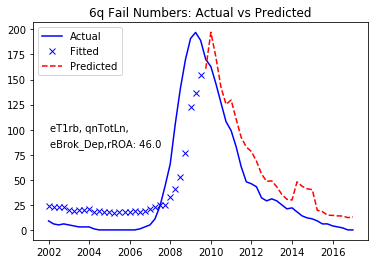

In [55]:
fx = list(fnbr.index)
plt.plot(fx, fnbr['f6'],'b', label='Actual')
plt.plot(fx, fnbr['f6_4f'],'b',ls=' ',marker='x', label='Fitted')
plt.plot(fx, fnbr['f6_4p'],'r--',lw=1.5, label='Predicted')
plt.annotate(dv4r[dv4r['idx']==4]['Annot1'].values[0], xy=(0.05, 0.5),\
             xycoords='axes fraction', fontsize=10) # var listing annotation
plt.annotate(dv4r[dv4r['idx']==4]['Annot2'].values[0], xy=(0.05, 0.43),\
             xycoords='axes fraction', fontsize=10) # var listing annotation
plt.legend(loc=2)
plt.title('6q Fail Numbers: Actual vs Predicted')
plt.show()

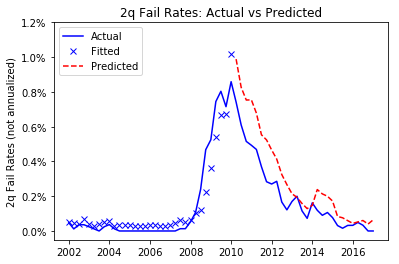

In [56]:
fx = list(fnbr.index)
plt.plot(fx, favg['f2'],'b', label='Actual')
plt.plot(fx, favg['f2_0f'],'b',ls=' ',marker='x', label='Fitted')
plt.plot(fx, favg['f2_0p'],'r--',lw=1.5, label='Predicted')
# convert decimals to percentages with % symbols:
ytix = np.arange(0,.0121,.002)  # list of ticks on y-axis
ylbl = ['{:3.1f}%'.format(x*100) for x in ytix] # mult by 100 and add % symbol
plt.yticks(ytix, ylbl)
plt.ylabel('2q Fail Rates (not annualized)')
plt.legend(loc=2)
plt.title('2q Fail Rates: Actual vs Predicted')
plt.show()

In [57]:
fx = list(fnbr.index)
plt.plot(fx, favg['f4'],'b', label='Actual')
plt.plot(fx, favg['f4_2f'],'b',ls=' ',marker='x', label='Fitted')
plt.plot(fx, favg['f4_2p'],'r--',lw=1.5, label='Predicted')
# convert decimals to percentages with % symbols:
ytix = np.arange(0,.0241,.004)  # list of ticks on y-axis
ylbl = ['{:3.1f}%'.format(x*100) for x in ytix] # mult by 100 and add % symbol
plt.yticks(ytix, ylbl)
plt.ylabel('Rolling 4q Fail Rates')
plt.legend(loc=2)
plt.title('4q Fail Rates: Actual vs Predicted')
plt.show()

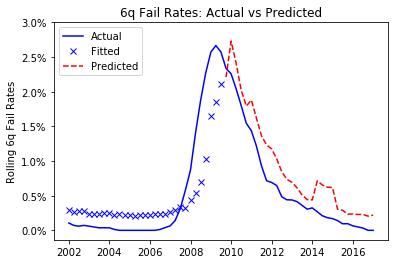

In [58]:
fx = list(fnbr.index)
plt.plot(fx, favg['f6'],'b', label='Actual')
plt.plot(fx, favg['f6_4f'],'b',ls=' ',marker='x', label='Fitted')
plt.plot(fx, favg['f6_4p'],'r--',lw=1.5, label='Predicted')
# convert decimals to percentages with % symbols:
ytix = np.arange(0,.0301,.005)  # list of ticks on y-axis
ylbl = ['{:3.1f}%'.format(x*100) for x in ytix] # mult by 100 and add % symbol
plt.yticks(ytix, ylbl)
plt.ylabel('Rolling 6q Fail Rates')
plt.legend(loc=2)
plt.title('6q Fail Rates: Actual vs Predicted')
plt.show()

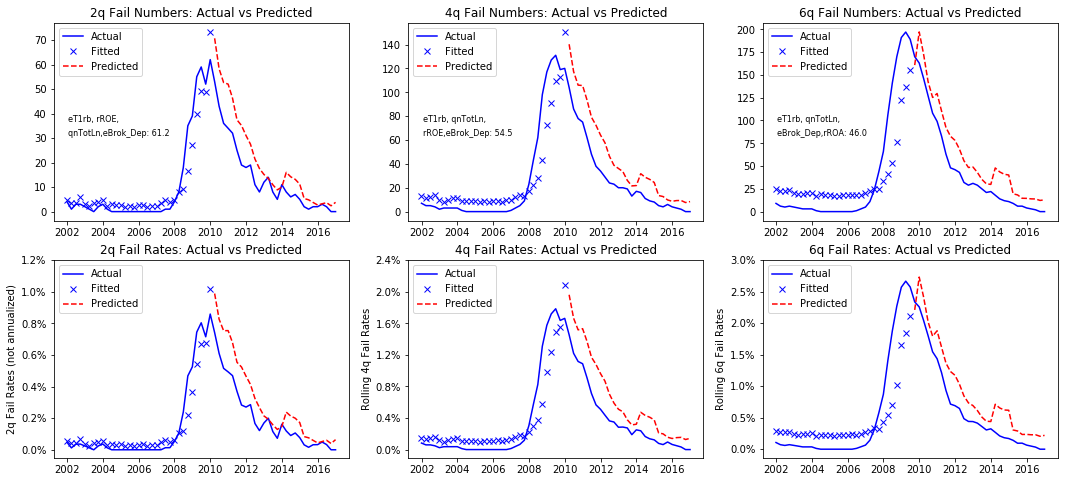

In [59]:
fx = list(fnbr.index)
params = plt.gcf()
plSize = params.get_size_inches()
params.set_size_inches( (plSize[0]*3, plSize[1]*2) )  ## double width, single height

plt.subplot(2, 3, 1)
plt.plot(fx, fnbr['f2'],'b', label='Actual')
plt.plot(fx, fnbr['f2_0f'],'b',ls=' ',marker='x', label='Fitted')
plt.plot(fx, fnbr['f2_0p'],'r--',lw=1.5, label='Predicted')
plt.legend(loc=2)
plt.title('2q Fail Numbers: Actual vs Predicted')
plt.annotate(dv4r[dv4r['idx']==0]['Annot1'].values[0], xy=(0.05, 0.5),\
             xycoords='axes fraction', fontsize=8) # var listing annotation
plt.annotate(dv4r[dv4r['idx']==0]['Annot2'].values[0], xy=(0.05, 0.43),\
             xycoords='axes fraction', fontsize=8) # var listing annotation

plt.subplot(2, 3, 2)
plt.plot(fx, fnbr['f4'],'b', label='Actual')
plt.plot(fx, fnbr['f4_2f'],'b',ls=' ',marker='x', label='Fitted')
plt.plot(fx, fnbr['f4_2p'],'r--',lw=1.5, label='Predicted')
plt.annotate(dv4r[dv4r['idx']==2]['Annot1'].values[0], xy=(0.05, 0.5),\
             xycoords='axes fraction', fontsize=8) # var listing annotation
plt.annotate(dv4r[dv4r['idx']==2]['Annot2'].values[0], xy=(0.05, 0.43),\
             xycoords='axes fraction', fontsize=8) # var listing annotation
plt.legend(loc=2)
plt.title('4q Fail Numbers: Actual vs Predicted')

plt.subplot(2, 3, 3)
plt.plot(fx, fnbr['f6'],'b', label='Actual')
plt.plot(fx, fnbr['f6_4f'],'b',ls=' ',marker='x', label='Fitted')
plt.plot(fx, fnbr['f6_4p'],'r--',lw=1.5, label='Predicted')
plt.annotate(dv4r[dv4r['idx']==4]['Annot1'].values[0], xy=(0.05, 0.5),\
             xycoords='axes fraction', fontsize=8) # var listing annotation
plt.annotate(dv4r[dv4r['idx']==4]['Annot2'].values[0], xy=(0.05, 0.43),\
             xycoords='axes fraction', fontsize=8) # var listing annotation
plt.legend(loc=2)
plt.title('6q Fail Numbers: Actual vs Predicted')

plt.subplot(2, 3, 4)
plt.plot(fx, favg['f2'],'b', label='Actual')
plt.plot(fx, favg['f2_0f'],'b',ls=' ',marker='x', label='Fitted')
plt.plot(fx, favg['f2_0p'],'r--',lw=1.5, label='Predicted')
# convert decimals to percentages with % symbols:
ytix = np.arange(0,.0121,.002)  # list of ticks on y-axis
ylbl = ['{:3.1f}%'.format(x*100) for x in ytix] # mult by 100 and add % symbol
plt.yticks(ytix, ylbl)
plt.ylabel('2q Fail Rates (not annualized)')
plt.legend(loc=2)
plt.title('2q Fail Rates: Actual vs Predicted')

plt.subplot(2, 3, 5)
plt.plot(fx, favg['f4'],'b', label='Actual')
plt.plot(fx, favg['f4_2f'],'b',ls=' ',marker='x', label='Fitted')
plt.plot(fx, favg['f4_2p'],'r--',lw=1.5, label='Predicted')
# convert decimals to percentages with % symbols:
ytix = np.arange(0,.0241,.004)  # list of ticks on y-axis
ylbl = ['{:3.1f}%'.format(x*100) for x in ytix] # mult by 100 and add % symbol
plt.yticks(ytix, ylbl)
plt.ylabel('Rolling 4q Fail Rates')
plt.legend(loc=2)
plt.title('4q Fail Rates: Actual vs Predicted')

plt.subplot(2, 3, 6)
plt.plot(fx, favg['f6'],'b', label='Actual')
plt.plot(fx, favg['f6_4f'],'b',ls=' ',marker='x', label='Fitted')
plt.plot(fx, favg['f6_4p'],'r--',lw=1.5, label='Predicted')
# convert decimals to percentages with % symbols:
ytix = np.arange(0,.0301,.005)  # list of ticks on y-axis
ylbl = ['{:3.1f}%'.format(x*100) for x in ytix] # mult by 100 and add % symbol
plt.yticks(ytix, ylbl)
plt.ylabel('Rolling 6q Fail Rates')
plt.legend(loc=2)
plt.title('6q Fail Rates: Actual vs Predicted')

plt.savefig('LR_'+alt+str(thresh)+'mm2_2009_nbrvsrate_allmods'+'.png', dpi=400, bbox_inches='tight')

plt.show()

In [60]:
fcol[-6:]

['f2_0', 'f2_1', 'f4_2', 'f4_3', 'f6_4', 'f6_5']

In [61]:
len(dff) # 444470

444470

In [62]:
ffb = dff[dff['FailDate']>'1999'][['IDRSSD','AsOf','Name','FailDate','eTotAst']+fcol[-6:]].groupby(['IDRSSD']).max()

In [63]:
ffb.sort_index(by='eTotAst',ascending=False,inplace=True)
ffb.reset_index(drop=False,inplace=True)

In [64]:
dff.columns

Index(['IDRSSD', 'AsOf', 'Name', 'State', 'eTotAst', 'rcTotLn', 'qnTotLn',
       'rNIM', 'rPPNR', 'rROA', 'rROE', 'rEff', 'eLn_Dep', 'aFF_TA',
       'eBrok_Dep', 'eT1rb', 'eTotrb', 'eALLL_Ln', 'lnTotAst', 'FailDate',
       'mtf', 'mtf2', 'f2', 'f4', 'f6', 'f8', 'Intercept', 'f2_0', 'f2_1',
       'f4_2', 'f4_3', 'f6_4', 'f6_5'],
      dtype='object')

In [65]:
ffb.tail()

IDRSSD       AsOf                     Name   FailDate  eTotAst      f2_0  \
471  371915 2003-12-31            RELIANCE BANK 2004-03-19  31375.0  0.755086   
472  740258 2009-03-31           BANK OF LEETON 2010-01-22  26441.0  0.448043   
473  187358 2014-03-31  FREEDOM STATE BANK, THE 2014-06-27  23218.0  0.000227   
474  901956 2007-12-31                HUME BANK 2008-03-07  19681.0  0.000648   
475  475934 2001-12-31     STATE BANK OF LATHAM 2014-06-20   6470.0  0.000030   

         f2_1      f4_2      f4_3      f6_4      f6_5  
471  0.750560  0.955656  0.871350  0.917425  0.961953  
472  0.421924  0.783641  0.691208  0.705402  0.810606  
473  0.000144  0.001010  0.000842  0.002414  0.002639  
474  0.000391  0.002492  0.003066  0.006437  0.005208  
475  0.000013  0.000143  0.000075  0.000273  0.000417

In [66]:
ffb['Rank'] = ffb['eTotAst'].rank(ascending=False)
ffb.head()

IDRSSD       AsOf                         Name   FailDate       eTotAst  \
0   480228 2016-12-31          BANK OF AMERICA, NA 2009-01-16  1.677490e+09   
1   476810 2016-12-31               CITIBANK, N.A. 2008-11-23  1.377279e+09   
2  1830035 2014-09-30        MBNA AMERICA BANK, NA 2009-01-16  1.967486e+08   
3   486752 2011-03-31  CITIBANK (SOUTH DAKOTA), NA 2008-11-23  1.579352e+08   
4  1225800 2009-06-30       MERRILL LYNCH BANK USA 2009-01-16  7.813389e+07   

       f2_0      f2_1      f4_2      f4_3      f6_4      f6_5  Rank  
0  0.001324  0.022334  0.004427  0.005700  0.010916  0.009172   1.0  
1  0.001438  0.022605  0.005154  0.006556  0.012377  0.010334   2.0  
2  0.000745  0.005060  0.005393  0.063148  0.150706  0.012319   3.0  
3  0.025529  0.007399  0.133337  0.125318  0.252417  0.259579   4.0  
4  0.011493  0.065318  0.072194  0.057454  0.154416  0.157718   5.0

In [67]:
dff[dff['mtf']>0][['IDRSSD','mtf']].head(6)

IDRSSD         mtf
1056    2451  102.704368
1057    2451   99.747428
1058    2451   96.757634
1059    2451   93.734984
1060    2451   90.712335
1061    2451   87.755395

In [68]:
############### CAUTION  CAUTION #########################################
## DO NOT RUN UNLESS.....
## short-cut to skip all earlier processing!!!!!!!!!!!!!!!!!
############### CAUTION  CAUTION #########################################

#dff = pd.read_csv('allbanks_f2468_roe0mm2_20091231.csv', index_col=0)
#dff['AsOf'] = pd.to_datetime(dff['AsOf'])
#dff['FailDate'] = pd.to_datetime(dff['FailDate'])
############### CAUTION  CAUTION #########################################

fcol = [x for x in list(dff.columns) if x[0:1]=='f']
xcol=['rcTotLn','qnTotLn','rNIM','rPPNR','rROA','rROE','rEff','eLn_Dep','aFF_TA','eBrok_Dep','eT1rb','eTotrb','eALLL_Ln','lnTotAst']
dmtf=dff[dff['mtf2']>0][['mtf2']+xcol+fcol].groupby('mtf2').mean()
targ = pd.to_datetime('2009-12-31')
thresh = 0
alt = 'roe' ## or alt = ''  # add rROE >=-200 screening test

dff.head(2)

IDRSSD       AsOf                    Name State  eTotAst   rcTotLn  \
0      37 2001-12-31  BANK OF HANCOCK COUNTY    GA  66624.0  0.320412   
1      37 2002-03-31  BANK OF HANCOCK COUNTY    GA  68766.0  0.261846   

    qnTotLn      rNIM     rPPNR      rROA    ...     f4  f6  f8  Intercept  \
0  0.202341  4.771308  2.035791  1.366385    ...      0   0   0        1.0   
1  0.199812  4.673793  1.952308  1.314604    ...      0   0   0        1.0   

           f2_0          f2_1          f4_2          f4_3          f6_4  \
0  1.816980e-08  2.457995e-08  2.658786e-07  1.808432e-08  3.640110e-07   
1  2.074132e-08  2.819496e-08  2.984160e-07  2.111511e-08  4.128278e-07   

       f6_5  
0  0.000002  
1  0.000002  

[2 rows x 33 columns]

In [69]:
dmtf.head()

rcTotLn    qnTotLn      rNIM     rPPNR      rROA        rROE  \
mtf2                                                                  
1.0   4.032292  14.277520  2.744724 -0.987102 -4.443886 -116.303051   
2.0   4.066220  13.442547  3.027529 -0.990879 -4.626149 -108.366116   
3.0   4.346972  14.278484  2.629438 -1.178521 -4.848716 -110.500314   
4.0   4.129677  13.961513  2.727437 -0.833990 -4.781487 -102.129647   
5.0   3.814518  12.866325  3.111152 -0.670703 -4.351847  -84.804744   

              rEff    eLn_Dep    aFF_TA  eBrok_Dep    ...      f2   f4   f6  \
mtf2                                                  ...                     
1.0    6775.081639  78.021080  9.183862  12.908276    ...     1.0  1.0  1.0   
2.0   14877.208771  78.096906  8.714879  10.462009    ...     1.0  1.0  1.0   
3.0    2987.168342  77.155422  7.639814  10.863542    ...     1.0  1.0  1.0   
4.0    8945.865312  84.402393  7.983841  13.783778    ...     1.0  1.0  1.0   
5.0   12004.751784  79.632231  7.637935  10.794229    ...     1.0  1.0  1.0   

       f8      f2_0      f2_1      f4_2      f4_3      f6_4      f6_5  
mtf2                                                                   
1.0   1.0  0.587028  0.604045  0.750002  0.664313  0.695277  0.783224  
2.0   1.0  0.540424  0.560895  0.722206  0.641634  0.675794  0.758421  
3.0   1.0  0.521555  0.539898  0.721095  0.643086  0.686186  0.765765  
4.0   1.0  0.475082  0.486350  0.685604  0.617099  0.664708  0.735598  
5.0   1.0  0.340474  0.361043  0.566347  0.517333  0.577399  0.631493  

[5 rows x 24 columns]

In [70]:
xm = list(dmtf.index)[0:25]
#dmtf.ix[0:25][['rcTotLn','qnTotLn','rROA','eT1rb']].plot()
plt.plot(xm,dmtf.ix[0:25]['eT1rb'],c='b',ls='-',lw=1.2,label='Tier1 RBC (eT1rb)')
plt.plot(xm,dmtf.ix[0:25]['qnTotLn'],c='r',ls='--',label='Non-Accr (qnTotLn)')
#plt.plot(xm,dmtf.ix[0:25]['rcTotLn'],c='b',label='NCO TotLn (r4q)')
plt.plot(xm,dmtf.ix[0:25]['rROA'],c='g',ls=':',lw=1.5,marker='.',label='ROA_4q (rROA)')
#plt.plot(xm,dmtf.ix[0:25]['eBrok_Dep'],c='g',ls='-.',lw=1.5,marker='x',label='Brok%Dep')
plt.plot(xm,[0]*25,'k',lw=.5)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ytix = np.arange(-5,15.1,5)  # list of ticks on y-axis
ylbl = ['{:3.0f}%'.format(x) for x in ytix] # mult by 100 and add % symbol
plt.yticks(ytix, ylbl)
plt.xlabel('Months-to-Failure')
plt.grid()
plt.title("Selected Ratios vs. Months-to-Failure")
plt.gca().invert_xaxis()  ## inverts x-axis!!
plt.savefig('LR_'+alt+str(thresh)+'mm2_2009_ratiosvsmtf'+'.png', dpi=300, bbox_inches='tight')
plt.show()

In [71]:
xm

[1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 20.0,
 21.0,
 22.0,
 23.0,
 24.0,
 25.0]

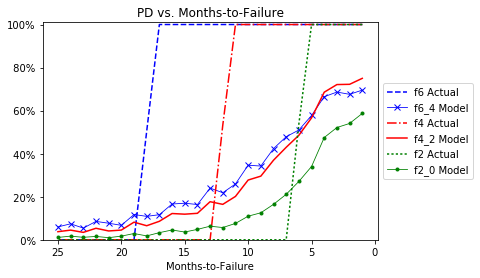

In [72]:
falt = ['f2_0','f4_2','f6_4']
#dmtf.ix[0:25][falt].plot()
plt.plot(xm,dmtf.ix[0:25]['f6'],c='b',ls='--',lw=1.5,label='f6 Actual')
plt.plot(xm,dmtf.ix[0:25]['f6_4'],c='b',ls='-',lw=.8,marker='x',label='f6_4 Model')
plt.plot(xm,dmtf.ix[0:25]['f4'],c='r',ls='-.',lw=1.5,label='f4 Actual')
plt.plot(xm,dmtf.ix[0:25]['f4_2'],c='r',lw=1.5,label='f4_2 Model')
plt.plot(xm,dmtf.ix[0:25]['f2'],c='g',ls=':',lw=1.5,label='f2 Actual')
plt.plot(xm,dmtf.ix[0:25]['f2_0'],c='g',ls='-',lw=.8,marker='.',label='f2_0 Model')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("PD vs. Months-to-Failure")
plt.ylim([0,1.01])
ytix = np.arange(0,1.1,.2)  # list of ticks on y-axis
ylbl = ['{:3.0f}%'.format(x*100) for x in ytix] # mult by 100 and add % symbol
plt.yticks(ytix, ylbl)
plt.xlabel('Months-to-Failure')
plt.gca().invert_xaxis()
plt.savefig('LR_'+alt+str(thresh)+'mm2_2009_pdsvsmtf'+'.png', dpi=300, bbox_inches='tight')
plt.show()

In [73]:
varlst = ['qnTotLn', 'rROA', 'rROE','eBrok_Dep', 'eT1rb','lnTotAst']
varlst

['qnTotLn', 'rROA', 'rROE', 'eBrok_Dep', 'eT1rb', 'lnTotAst']

In [74]:
df11=dff[(dff['AsOf']=='2010-12-31')&(dff['FailDate']>'2011-01-01')&(dff['FailDate']<'2012-01-01')]
df11.sort_index(by='FailDate',inplace=True)
len(df11) # 75

75

In [75]:
df11[['FailDate','Name','State','f2_0','f4_2','f6_4']][0:15]

FailDate                            Name State      f2_0      f4_2  \
431930 2011-01-07                     LEGACY BANK    AZ  0.369447  0.662182   
167336 2011-01-21      ENTERPRISE BANKING COMPANY    GA  0.904162  0.985704   
18784  2011-01-28           FIRST STATE BANK, THE    OK  0.000579  0.001730   
425187 2011-01-28                   FIRSTIER BANK    CO  0.979686  0.996981   
79899  2011-01-28            FIRST COMMUNITY BANK    NM  0.863226  0.973359   
434628 2011-02-04  COMMUNITY FIRST BANK - CHICAGO    IL  0.202498  0.474166   
407243 2011-02-04              NORTH GEORGIA BANK    GA  0.969234  0.995705   
423989 2011-02-04             AMERICAN TRUST BANK    GA  0.922173  0.985856   
256647 2011-02-11              PEOPLES STATE BANK    MI  0.942476  0.988253   
389224 2011-02-11            CANYON NATIONAL BANK    CA  0.701714  0.917501   
73336  2011-02-11               BADGER STATE BANK    WI  0.167351  0.420509   
409938 2011-02-11   SUNSHINE STATE COMMUNITY BANK    FL  0.883075  0.979421   
384281 2011-02-18      CITIZENS BANK OF EFFINGHAM    GA  0.874834  0.973369   
91476  2011-02-18                  HABERSHAM BANK    GA  0.851968  0.970404   
390879 2011-03-11                     LEGACY BANK    WI  0.974206  0.996698   

            f6_4  
431930  0.331050  
167336  0.977683  
18784   0.004410  
425187  0.967104  
79899   0.858734  
434628  0.337694  
407243  0.973021  
423989  0.905784  
256647  0.904814  
389224  0.744690  
73336   0.330722  
409938  0.877545  
384281  0.863428  
91476   0.899876  
390879  0.991465

In [76]:
df11[fcol].mean()

f2      0.453333
f4      1.000000
f6      1.000000
f8      1.000000
f2_0    0.426198
f2_1    0.457138
f4_2    0.652771
f4_3    0.581258
f6_4    0.636649
f6_5    0.715429
dtype: float64

In [77]:
df11.to_csv("2011failedbks_pds_20091231_"+alt+str(thresh)+"mm2.csv")

In [78]:
db11=dff[(dff['AsOf']=='2010-12-31')]
db11.sort_index(by='eTotAst',ascending=False,inplace=True)
db11[['Name']+fcol].head(10)

Name  f2  f4  f6  f8      f2_0      f2_1  \
292683       JPMORGAN CHASE BANK, NA   0   0   0   0  0.000795  0.014612   
164858           BANK OF AMERICA, NA   0   0   0   0  0.000511  0.008460   
163094                CITIBANK, N.A.   0   0   0   0  0.000057  0.001040   
153999          WELLS FARGO BANK, NA   0   0   0   0  0.000569  0.009063   
173466                  U.S. BANK NA   0   0   0   0  0.000823  0.008681   
280518                  PNC BANK, NA   0   0   0   0  0.000265  0.002779   
363635         FIA CARD SERVICES, NA   0   0   0   0  0.000068  0.000392   
185446  BANK OF NEW YORK MELLON, THE   0   0   0   0  0.000236  0.002334   
141426             HSBC BANK USA, NA   0   0   0   0  0.000209  0.001728   
170630                 TD BANK, N.A.   0   0   0   0  0.000247  0.000947   

            f4_2      f4_3      f6_4      f6_5  
292683  0.002995  0.003528  0.007858  0.006913  
164858  0.002138  0.001997  0.005041  0.005208  
163094  0.000310  0.000174  0.000691  0.000974  
153999  0.002168  0.002135  0.004909  0.004990  
173466  0.002789  0.003228  0.006397  0.005865  
280518  0.001146  0.000896  0.002477  0.002917  
363635  0.000381  0.000183  0.000712  0.001140  
185446  0.000925  0.000835  0.002103  0.002212  
141426  0.000951  0.000742  0.002194  0.002526  
170630  0.001464  0.000849  0.003102  0.004301

In [79]:
db11.to_csv("2011allbks_pds_20101231_"+alt+str(thresh)+"mm2.csv")

In [80]:
len(dff) # 444470

444470

In [81]:
varlst = ['qnTotLn', 'rROA', 'rROE','eBrok_Dep', 'eT1rb','lnTotAst']
varlst

['qnTotLn', 'rROA', 'rROE', 'eBrok_Dep', 'eT1rb', 'lnTotAst']

In [82]:
dff.to_csv("allbanks_f2468_"+alt+str(thresh)+"mm2_"+str(targ.year)+str(targ.month)+str(targ.day)+".csv")

In [83]:
"allbanks_f2468_"+alt+str(thresh)+"mm2_"+str(targ.year)+str(targ.month)+str(targ.day)+".csv"

'allbanks_f2468_roe0mm2_20091231.csv'

In [84]:
dfr.columns

Index(['IDRSSD', 'AsOf', 'Name', 'State', 'eTotAst', 'rcTotLn', 'qnTotLn',
       'rNIM', 'rPPNR', 'rROA', 'rROE', 'rEff', 'eLn_Dep', 'aFF_TA',
       'eBrok_Dep', 'eT1rb', 'eTotrb', 'eALLL_Ln', 'lnTotAst', 'FailDate',
       'mtf', 'mtf2', 'f2', 'f4', 'f6', 'f8'],
      dtype='object')

In [85]:
len(dfr), len(dff) # 454782, 444470

(454782, 444470)

In [86]:
len(dfh) # 259210

259210

In [87]:
dfh.to_csv("modeldata_f2468_"+alt+str(thresh)+"mm2_"+str(targ.year)+str(targ.month)+str(targ.day)+".csv")

In [88]:
"modeldata_f2468_"+alt+str(thresh)+"mm2_"+str(targ.year)+str(targ.month)+str(targ.day)+".csv"

'modeldata_f2468_roe0mm2_20091231.csv'

In [89]:
dfh.head(2)

IDRSSD       AsOf                    Name FailDate  f2  f4  f6  f8  \
0      37 2001-12-31  BANK OF HANCOCK COUNTY      NaT   0   0   0   0   
1      37 2002-03-31  BANK OF HANCOCK COUNTY      NaT   0   0   0   0   

    rcTotLn   qnTotLn    ...         eT1rb     eTotrb  eALLL_Ln   lnTotAst  \
0  0.320412  0.202341    ...     31.394061  32.659950  2.377511  11.106820   
1  0.261846  0.199812    ...     31.128485  32.396358  2.522930  11.138465   

           f2_0          f2_1          f4_2          f4_3          f6_4  \
0  1.816980e-08  2.457995e-08  2.658786e-07  1.808432e-08  3.640110e-07   
1  2.074132e-08  2.819496e-08  2.984160e-07  2.111511e-08  4.128278e-07   

       f6_5  
0  0.000002  
1  0.000002  

[2 rows x 28 columns]

In [90]:
dv4b

idx  fx     v1        r1       v2        r2         v3        r3  \
0  0.0  f2  eT1rb  0.522181     rROE  0.572503    qnTotLn  0.595651   
1  0.0  f2  eT1rb  0.522181     rROE  0.572503    qnTotLn  0.595651   
2  3.0  f4  eT1rb  0.399541  qnTotLn  0.485642       rROE  0.517804   
3  2.0  f4  eT1rb  0.399541  qnTotLn  0.485642       rROA  0.520306   
4  4.0  f6  eT1rb  0.292186  qnTotLn  0.398684  eBrok_Dep  0.432376   
5  4.0  f6  eT1rb  0.292186  qnTotLn  0.398684  eBrok_Dep  0.432376   

          v4        r4       Int        c1        c2        c3        c4  
0  eBrok_Dep  0.611862 -2.799821 -0.473018 -0.024956  0.084633  0.034710  
1   lnTotAst  0.605721 -6.621866 -0.450454 -0.028631  0.084570  0.310076  
2  eBrok_Dep  0.544661 -2.201785 -0.405928  0.112205 -0.028430  0.041345  
3  eBrok_Dep  0.543345 -0.967992 -0.524373  0.116511 -0.308563  0.038837  
4       rROA  0.460139 -1.308207 -0.418959  0.145417  0.042005 -0.288694  
5       rROE  0.458442 -2.075903 -0.346558  0.140125  0.043327 -0.025636

In [91]:
fcol

['f2', 'f4', 'f6', 'f8', 'f2_0', 'f2_1', 'f4_2', 'f4_3', 'f6_4', 'f6_5']

In [92]:
dpc0912 = dff[dff['AsOf']=='2009-12-31'][fcol[-6:]].quantile(np.arange(.01,1,.005))
dpc0912[['f2_0','f4_2','f6_4']].plot()
plt.ylim([0,.1])
plt.xlim([.85,1])
plt.legend(loc=2)

In [93]:
dpc0914 = dff[dff['AsOf']>'2009-01-01'][fcol[-6:]].quantile(np.arange(.01,1,.005))
dpc0914[['f2_0','f4_2','f6_4']].plot()
plt.ylim([0,.1])
plt.xlim([.9,1])
plt.legend(loc=2)

In [94]:
dpc96 = dff[['AsOf']+fcol[-6:]].groupby('AsOf').quantile(.96)
dpc96[['f2_0','f4_2','f6_4']].plot()

In [95]:
dpc90p = dff[['AsOf']+fcol[-6:]].groupby('AsOf').quantile([.9,.92,.94,.96,.98])
dpc90p = dpc90p.unstack(1)
#dpc90p=dpc90p.swaplevel(0,1,axis=1)
dpc90p.sort_index(axis=1,inplace=True)
dpc90p.head(2)

f2_0                                              f2_1  \
                0.90      0.92      0.94      0.96      0.98      0.90   
AsOf                                                                     
2001-12-31  0.000591  0.000653  0.000755  0.000930  0.001373  0.000655   
2002-03-31  0.000571  0.000647  0.000739  0.000899  0.001346  0.000632   

                                                      ...         f6_4  \
                0.92      0.94      0.96      0.98    ...         0.90   
AsOf                                                  ...                
2001-12-31  0.000738  0.000856  0.001086  0.001629    ...     0.004779   
2002-03-31  0.000710  0.000823  0.001034  0.001545    ...     0.004692   

                                                        f6_5            \
                0.92      0.94      0.96      0.98      0.90      0.92   
AsOf                                                                     
2001-12-31  0.005318  0.006084  0.007674  0.011588  0.004325  0.004778   
2002-03-31  0.005309  0.006108  0.007496  0.011538  0.004282  0.004799   

                                          
                0.94      0.96      0.98  
AsOf                                      
2001-12-31  0.005454  0.006748  0.010242  
2002-03-31  0.005508  0.006723  0.010497  

[2 rows x 30 columns]

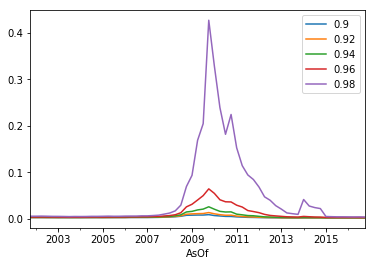

In [96]:
dpc90p['f4_2'].plot()

In [97]:
dfr0916 = dfr[dfr['AsOf']>'2009-01-01']
len(dfr0916) # 219104

219104

In [98]:
dfr.columns

Index(['IDRSSD', 'AsOf', 'Name', 'State', 'eTotAst', 'rcTotLn', 'qnTotLn',
       'rNIM', 'rPPNR', 'rROA', 'rROE', 'rEff', 'eLn_Dep', 'aFF_TA',
       'eBrok_Dep', 'eT1rb', 'eTotrb', 'eALLL_Ln', 'lnTotAst', 'FailDate',
       'mtf', 'mtf2', 'f2', 'f4', 'f6', 'f8'],
      dtype='object')

In [99]:
dfr0916.sort_index(by=['AsOf','eTotAst'],ascending=[True,False],inplace=True)
dfr0916.reset_index(drop=True,inplace=True)
dfr0916.tail(2)

IDRSSD       AsOf                               Name State  eTotAst  \
219102  2960788 2016-12-31  WHEATON COLLEGE TRUST COMPANY, NA    IL   3362.0   
219103  2337335 2016-12-31               UMB BANK & TRUST, NA    MO   3025.0   

        rcTotLn  qnTotLn        rNIM     rPPNR      rROA ...       eTotrb  \
219102      0.0      0.0    0.447392 -0.116848 -0.087636 ...  4352.000000   
219103      0.0      0.0  500.000000  0.165385  0.132308 ...   102.998296   

        eALLL_Ln  lnTotAst  FailDate  mtf  mtf2  f2  f4  f6 f8  
219102       0.0  8.120291       NaT  NaN   NaN   0   0   0  0  
219103       0.0  8.014666       NaT  NaN   NaN   0   0   0  0  

[2 rows x 26 columns]

In [100]:
dfr0916.to_csv("allbanks_f2468r_"+alt+str(thresh)+"mm2_2009_2016"+".csv")

In [101]:
dfr0916.tail()

IDRSSD       AsOf                                           Name  \
219099  2502825 2016-12-31                             DSRM NATIONAL BANK   
219100  3952904 2016-12-31  CANANDAIGUA NATIONAL TRUST COMPANY OF FLORIDA   
219101  3268173 2016-12-31                       EMIGRANT MERCANTILE BANK   
219102  2960788 2016-12-31              WHEATON COLLEGE TRUST COMPANY, NA   
219103  2337335 2016-12-31                           UMB BANK & TRUST, NA   

       State  eTotAst  rcTotLn  qnTotLn        rNIM     rPPNR      rROA ...  \
219099    NM   3734.0      0.0      0.0    1.012043  1.511777  0.944861 ...   
219100    FL   3682.0      0.0      0.0    0.393820 -7.762001 -5.327924 ...   
219101    NY   3471.0      0.0      0.0    0.115224 -1.430104 -0.886664 ...   
219102    IL   3362.0      0.0      0.0    0.447392 -0.116848 -0.087636 ...   
219103    MO   3025.0      0.0      0.0  500.000000  0.165385  0.132308 ...   

             eTotrb  eALLL_Ln  lnTotAst  FailDate  mtf  mtf2  f2  f4  f6 f8  
219099   286.715196       0.0  8.225235       NaT  NaN   NaN   0   0   0  0  
219100   455.455712       0.0  8.211211       NaT  NaN   NaN   0   0   0  0  
219101   429.046243       0.0  8.152198       NaT  NaN   NaN   0   0   0  0  
219102  4352.000000       0.0  8.120291       NaT  NaN   NaN   0   0   0  0  
219103   102.998296       0.0  8.014666       NaT  NaN   NaN   0   0   0  0  

[5 rows x 26 columns]

In [102]:
dff0916 = dff[dff['AsOf']>'2009-01-01']
len(dff0916) # 214485

214485

In [103]:
dff0916.sort_index(by=['AsOf','eTotAst'],ascending=[True,False],inplace=True)
dff0916.reset_index(drop=True,inplace=True)
dff0916.head(2)

IDRSSD       AsOf                     Name State       eTotAst   rcTotLn  \
0  852218 2009-03-31  JPMORGAN CHASE BANK, NA    OH  1.688164e+09  1.373904   
1  480228 2009-03-31      BANK OF AMERICA, NA    NC  1.432862e+09  1.475853   

    qnTotLn      rNIM     rPPNR      rROA    ...     f4  f6  f8  Intercept  \
0  2.496176  2.523947  1.918733  0.699537    ...      0   0   0        1.0   
1  3.152932  2.483742  1.831558  0.455510    ...      0   0   0        1.0   

       f2_0      f2_1      f4_2      f4_3      f6_4      f6_5  
0  0.000926  0.016576  0.003195  0.003976  0.007878  0.006744  
1  0.001287  0.022138  0.004427  0.005700  0.010916  0.009172  

[2 rows x 33 columns]

In [104]:
dff0916.to_csv("allbanks_f2468_"+alt+str(thresh)+"mm2_2009_2016"+".csv")

In [105]:
dff201612 = dff[dff['AsOf']=='2016-12-31']
len(dff201612)

5904

In [106]:
dff201612.to_csv("allbanks_f2468r_"+alt+str(thresh)+"mm2_201612"+".csv")

In [107]:
"allbanks_f2468r_"+alt+str(thresh)+"mm2_201612"+".csv"

'allbanks_f2468r_roe0mm2_201612.csv'

In [108]:
dff201612.tail()

IDRSSD       AsOf                      Name State    eTotAst  \
454649  4210227 2016-12-31                  NBH BANK    CO  4556051.0   
454709  4262534 2016-12-31        CADENCE BANK, N.A.    AL  9515975.0   
454732  4262543 2016-12-31  ALOSTAR BANK OF COMMERCE    AL   961500.0   
454765  4536084 2016-12-31      BANK OF BIRD-IN-HAND    PA   170127.0   
454781  4845861 2016-12-31              PRIMARY BANK    NH    90549.0   

         rcTotLn   qnTotLn      rNIM     rPPNR      rROA    ...     f4  f6  \
454649  0.779944  1.064744  3.418487  1.344526  0.548797    ...      0   0   
454709  0.648692  1.729245  3.485834  1.823922  0.834765    ...      0   0   
454732  0.451237  1.044196  3.351716  1.347210  0.759912    ...      0   0   
454765  0.001503  0.000000  2.540638  0.868445  0.479930    ...      0   0   
454781  0.000000  0.000000  2.500239 -2.323936 -3.615393    ...      0   0   

        f8  Intercept          f2_0          f2_1          f4_2          f4_3  \
454649   0        1.0  2.218730e-04  7.197055e-04  8.970792e-04  7.583511e-04   
454709   0        1.0  4.050572e-04  1.048198e-03  1.787316e-03  1.390345e-03   
454732   0        1.0  1.690168e-06  4.300000e-06  1.377259e-05  3.074354e-06   
454765   0        1.0  4.690245e-04  5.297481e-04  1.643436e-03  1.694148e-03   
454781   0        1.0  6.240875e-09  1.053034e-08  1.175688e-07  1.665627e-08   

                f6_4      f6_5  
454649  1.942702e-03  0.002138  
454709  3.711772e-03  0.004391  
454732  2.362713e-05  0.000061  
454765  3.499637e-03  0.003421  
454781  4.160919e-07  0.000001  

[5 rows x 33 columns]